a


In [4]:
import math
import control
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from control import TransferFunction
import scipy.io.wavfile as wavf
import sounddevice as sd
import IPython.display as ipd

NUMERO_REPETICOES_SINAL = 14

In [5]:

def plotar(dados_x, dados_y, title, dados_label="None", dados_type="", x_label='Tempo em segundos', y_label='Amplitude'):
    plt.figure()
    plt.plot(dados_x, dados_y, dados_type, label=dados_label)
    plt.title(title)
    plt.legend()
    plt.grid(True, which='both')
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    return plt


def criarImpulso(Ns, Ds, vetor_tempo, exponencial=None, exibir=False, xlim=[0, 0.006], amplitude=1):
    """
    Recebe vetores Ns e Ds, representando os multiplicadores do numerador e denominador da função F(s) de La Place e
    retornar um vetor do resultado de aplicar um impulso nessa F(s)
    """

    # Cria a funcao Gs
    Gs = TransferFunction(Ns, Ds)
    # Faz a Gs sofrer impulso
    x_impulso, y_impulso = control.impulse_response(Gs, vetor_tempo)
    # Exibe em uma figura o sinal obtido
    if (exibir):
        print(f"N(s) = {Ns}")
        print(f"D(s) = {Ds}")
        print(f"Função G(s): {Gs}")

        plt.figure()
        plt.plot(x_impulso, y_impulso)
        plt.title(f"b = {Ds[1]}, c = {Ds[2]})")
        plt.grid(True, which='both')
        plt.axhline(y=0, color='k')
        plt.axvline(x=0, color='k')
        if (exponencial):
            plt.plot(vetor_tempo, exponencial[0] * np.exp(-exponencial[1] * vetor_tempo))
        plt.xlim(xlim)
        plt.xlabel('Tempo em segundos')
        plt.ylabel('Amplitude')
    return x_impulso, y_impulso

def calculaErroAjuste(gt, yt, t):
    """
    Calcula o erro entre um vetor gt e yt, do mesmo tamanho, fazendo a média do quadrado da diferenca entre cada
    ponto dos vetores
    """
    erro = []
    passou = 0
    for i in range(len(t)):
        if( i < len(gt) and i < len(yt)):
            erro.append((yt[i] - gt[i]) ** 2)

    return np.mean(erro)

def get_menor_erro(iteracoes):
    """
    Retorna os valores de b, c e amplitude da iteração com menor erro
    """
    return min(iteracoes, key=iteracoes.get).split('/')

def testar_impulso_Forca_bruta(b_range, c_range, amplitude_range, trecho_t, trecho_Vp):
    """
    Testa valores de b, c e amplitude especificados pelos ranges, retornando a combinação de menor erro
    """
    cont = 0
    iteracoes = {}
    for b in b_range:
        for c in c_range:
            for amp in amplitude_range:
                if (b ** 2 - 4 * c) < 0:
                    # Define a expressão
                    Ns = [1]
                    Ds = [1, b, c]
                    # Cria o impulso
                    x_impulso, y_impulso = criarImpulso(Ns, Ds, vetor_tempo=trecho_t, amplitude=amp, exibir=False)

                    # todo adicionar erro com o impulso e o valor real
                    iteracoes[f"{b}/{c}/{amp}"] = calculaErroAjuste(trecho_Vp, y_impulso, trecho_t)
    #Retorna impulso com menor erro
    return get_menor_erro(iteracoes)

def impulso(amp, b, c, trecho_t): #todo eliminar isso
    """
    Cria um impulso a partir de valores de amp, b e c
    """
    Ns = [float(amp)]
    Ds = [1, float(b), float(c)]
    return criarImpulso(Ns, Ds, vetor_tempo=trecho_t, amplitude = float(amp))

def criarGs(b, c, amp):
    """
    Cria a funcão Gs a partir de b, c e amp
    """
    return TransferFunction([amp], [b, c])

def repetir_array(array, n):
    """
    Retorna um array repetido n vezes
    """
    aux = np.array([])
    for i in range(n):
        aux = np.concatenate((aux, array))
    return aux

def get_polos(amp, b, c):
    """
    Calcula e retorna os pólos da função de LaPlace, a partir dos valores de b, c e amplitude
    """
    Ns = [float(amp)]
    Ds = [1, float(b), float(c)]
    Gs = TransferFunction(Ns, Ds)
    polos = Gs.pole()
    return [(polos[0].real, polos[0].imag), (polos[1].real, polos[1].imag)]

def play_vogal(x_impulso, x_impulso_auto, Vp, y_impulso, y_impulso_auto, t, duration=2):
    """
    Cria uma interface simples via terminal para escutar o som original e os gerados pelo programa
    """
    numero_para_x_segundos = lambda x,tempo: math.ceil(x/tempo[-1])
    freq_amostragem_original = len(t) / (t[-1] - t[0])
    freq_amostragem_sintetico_bruta = len(x_impulso) / (x_impulso[-1] - x_impulso[0])
    freq_amostragem_sintetico_auto = len(x_impulso_auto) / (x_impulso_auto[-1] - x_impulso_auto[0])
    op = None

    while (op != 0):
        print("Digite uma opção: \n1) Ouvir som original\n2) Ouvir som sintético gerado por Força Bruta\n3) Ouvir som sintético gerado Automaticamente\n0) Sair")
        op = int(input("Opção: "))
        if (op == 0):
            break
        elif (op == 1):
            sd.playrec(data=repetir_array(Vp, numero_para_x_segundos(tempo=t, x=duration)), samplerate=freq_amostragem_original)
        elif (op == 2):
            sd.play(data=repetir_array(y_impulso, numero_para_x_segundos(tempo=x_impulso, x=duration)), samplerate=freq_amostragem_sintetico_bruta)
        elif (op == 3):
            sd.play(data=repetir_array(y_impulso_auto, numero_para_x_segundos(tempo=x_impulso_auto, x=duration)), samplerate=freq_amostragem_sintetico_auto)
        else:
            print("Opção inválida")


def desenharLaplace(Ns, Ds):
    """
    Desenha o gráfico 3D de funcão de Laplace especificada
    """

    # Define a função de Z
    fun = lambda sigma, omega: np.absolute(Ns[0] / ((sigma + (1j * omega))**2 + Ds[0]*(sigma + (1j * omega)) + Ds[1]))

    # Escopo de sigma e omega
    w = np.linspace(-4000*np.pi, 4000*np.pi, 25)
    s = np.linspace(-4000*np.pi, 4000*np.pi, 25)

    # Mágica do numpy + matplotlib
    X, Y = np.meshgrid(s, w)
    Z = fun(X, Y)

    plt.figure()
    ax = plt.axes(projection="3d")
    ax.plot_wireframe(X, Y, Z, color='green')
    ax.set_xlabel('omega')
    ax.set_ylabel('sigma')
    ax.set_zlabel('z')

    # Deixar mais bonito
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='winter', edgecolor='none')
    ax.set_title('Laplace')

<module 'matplotlib.pyplot' from 'c:\\Users\\rafae\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

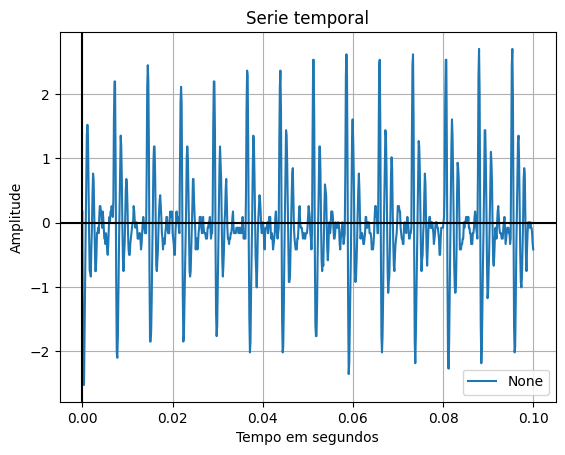

In [6]:
#Arquvio 'Voz.mat" baixado de https://github.com/vparro/sinais/blob/master/6%20-%20An%C3%A1lise%20de%20voz/Voz.mat
data = scipy.io.loadmat('Voz.mat')

# Carrega os valores de tempo
t = data['t']
t = np.squeeze(np.asarray(t))  # Transforma em array

# Carrega os valores da amplitude
Vp = data['Vp']
Vp = np.squeeze(np.asarray(Vp))  # Transforma em array

# Exibe a serie temporal carregada
plotar(t, Vp, title="Serie temporal")

<module 'matplotlib.pyplot' from 'c:\\Users\\rafae\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

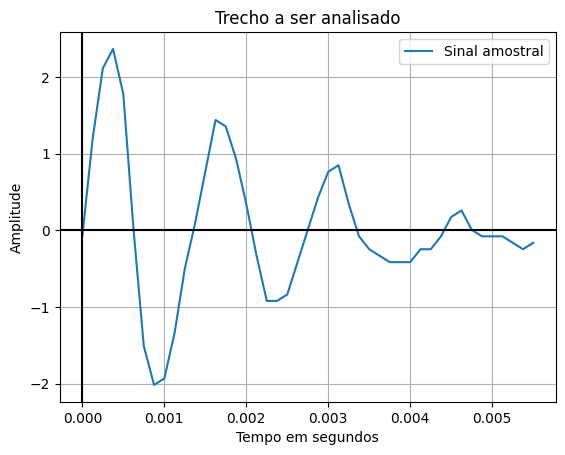

In [7]:
# Separa um trecho do sinal (Escolhido manualmente)
tempoInicial = 348  # posição no vetor t
tempoFinal = 393

# Recorta os trechos
trecho_t = t[0:tempoFinal - tempoInicial] # Desloca o trecho para o eixo y
trecho_Vp = Vp[tempoInicial:tempoFinal]

# Exibe o trecho recortado
plotar(trecho_t, trecho_Vp, dados_label="Sinal amostral", title="Trecho a ser analisado")

Frequência aproximada do trecho: 705.0 Hz e ω = 4429.6456415616085


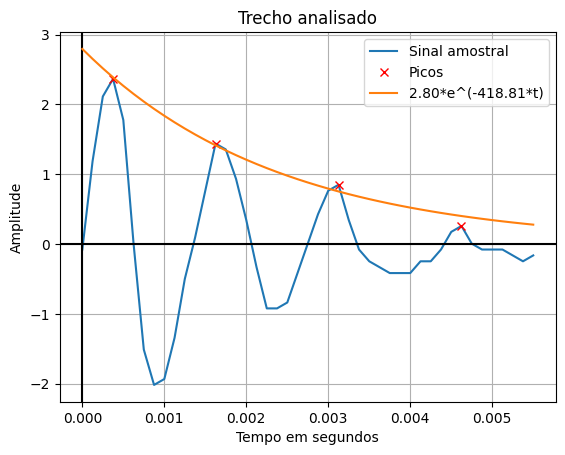

In [8]:
#### Calcula parâmetros do trecho (frequência e amortecimento)

# Encontrar picos
peaks, _ = find_peaks(trecho_Vp)

## Frequência
peaks_distance = []
for i in range(len(peaks) - 1):
    peaks_distance.append(trecho_t[peaks[i + 1]] - trecho_t[peaks[i]])

mean_distance = np.mean(peaks_distance)

# freq = 1/T    e T = distancia dos picos
trecho_freq = 1 / mean_distance
# w = f * 2 * pi
trecho_omega = trecho_freq * 2 * np.pi

print(f"Frequência aproximada do trecho: {trecho_freq} Hz e ω = {trecho_omega}")

## Amortecimento
result, _ = curve_fit(lambda x, k, m: m * np.exp(-k * x), trecho_t[peaks], trecho_Vp[peaks])
k, m = result

# Definição dos polos
polos_im = np.array([-trecho_omega, trecho_omega])
polos_re = np.array([-k, -k])

# Plotando o trecho com os parâmetros encontrados
trecho_plot = plotar(trecho_t, trecho_Vp, dados_label="Sinal amostral", title="Trecho analisado")
trecho_plot.plot(trecho_t[peaks], trecho_Vp[peaks], "xr", label="Picos")  # Plota os picos com pontos vermelho
trecho_plot.plot(trecho_t, m * np.exp(-k * trecho_t), label=f"{m:.2f}*e^(-{k:.2f}*t)")  # Plota a exponencial
trecho_plot.legend()

<module 'matplotlib.pyplot' from 'c:\\Users\\rafae\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

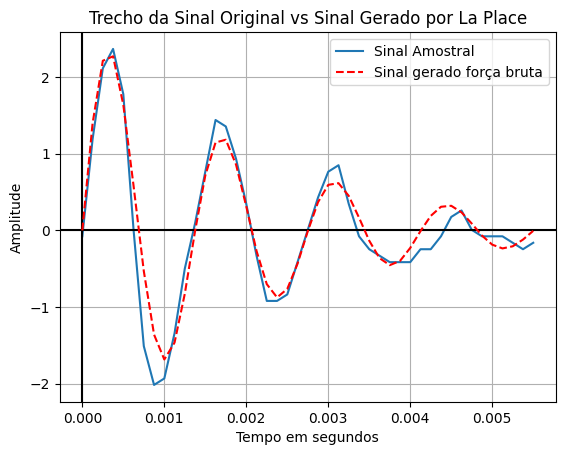

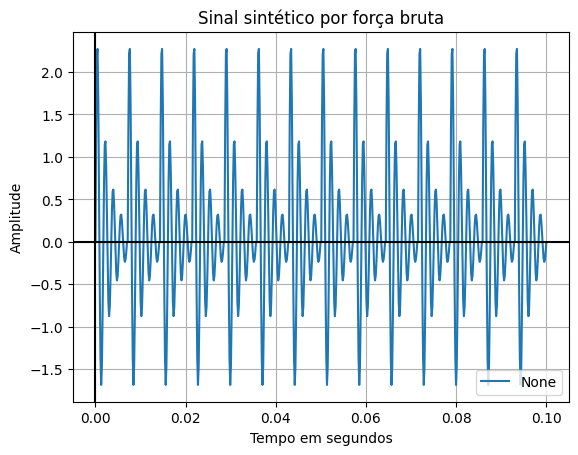

In [9]:
# Calculando o G(s) do trecho na força bruta

b_range = np.linspace(950, 980, 20)
c_range = np.linspace(21000000, 22000000, 20)
amplitude_range = np.linspace(12500, 14000, 30)

# Calcula os melhores valores de b, c e amplitude com base no menor erro
b, c, amp = testar_impulso_Forca_bruta(b_range, c_range, amplitude_range, trecho_t=trecho_t, trecho_Vp=trecho_Vp)

# Cria um impulso com base nos valores b, c e amp encontrados
x_impulso, y_impulso = impulso(amp, b, c, trecho_t=trecho_t)

# Plota o trecho original comparando o trecho gerado por força bruta
plot_forca_bruta = plotar(trecho_t, trecho_Vp,
                          title= "Trecho da Sinal Original vs Sinal Gerado por La Place",
                          dados_label="Sinal Amostral",)
plot_forca_bruta.plot(x_impulso, y_impulso, 'r--', label="Sinal gerado força bruta")
plot_forca_bruta.legend()

# Define os vetores para criar a serie sintética a partir do trecho
numero_pontos = len(y_impulso) * NUMERO_REPETICOES_SINAL
trecho_impulso_t = np.linspace(0, t[-1], numero_pontos)

# Plotar o sinal gerado por força bruta
plotar(trecho_impulso_t, repetir_array(y_impulso, NUMERO_REPETICOES_SINAL), title="Sinal sintético por força bruta")

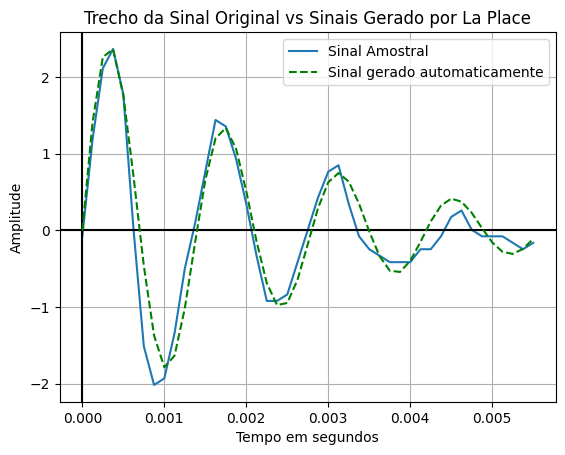

In [10]:
# Calculando o G(s) do trecho de forma automática
## Pega valores de b e c pelos parâmetros do trecho:
b_auto = 2*k    #k é o expoente calculado do fit da exponencial nos picos do trecho
c_auto = trecho_omega**2 + b_auto**2

# Cria o impulso baseado nos valores de b e c automáticos
x_impulso_auto, y_impulso_auto = impulso(amp, b_auto, c_auto, trecho_t=trecho_t)

# Plota o trecho do sinal original com a gerada por La Place automaticamente
plot_automatico = plotar(trecho_t, trecho_Vp,
                         title= "Trecho da Sinal Original vs Sinais Gerado por La Place",
                         dados_label="Sinal Amostral")
plot_automatico.plot(x_impulso_auto, y_impulso_auto, 'g--', label="Sinal gerado automaticamente")
plot_automatico.legend()

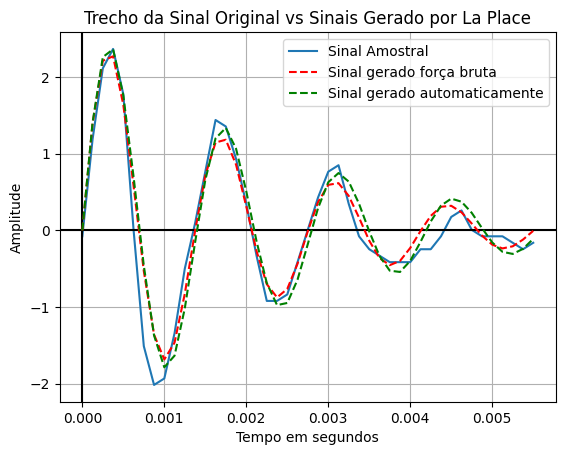

In [11]:
# Comparando o resultado a serie original com o resultado da força bruta e automático
serie_resposta_plot = plotar(trecho_t, trecho_Vp, title= "Trecho da Sinal Original vs Sinais Gerado por La Place", dados_label="Sinal Amostral")
serie_resposta_plot.plot(x_impulso, y_impulso, 'r--', label="Sinal gerado força bruta")
serie_resposta_plot.plot(x_impulso_auto, y_impulso_auto, 'g--', label="Sinal gerado automaticamente")
serie_resposta_plot.legend()

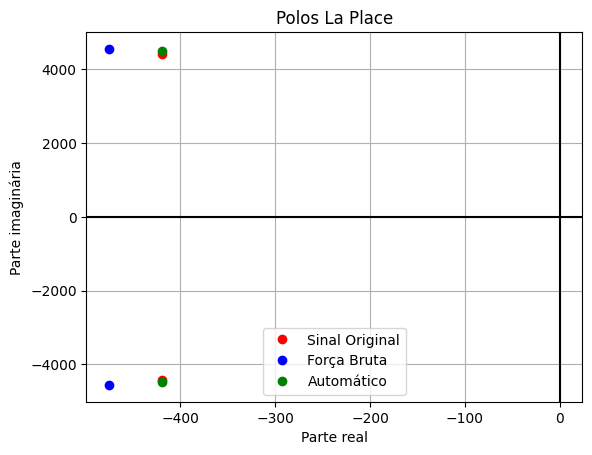

In [12]:
# Definindo os polos de LaPlace

# Cria o plot com os valores iniciais
polos_plot = plotar(polos_re, polos_im, dados_type='ro', title="Polos La Place", x_label="Parte real", y_label="Parte imaginária", dados_label="Sinal Original")

# Polos de G(s) por força bruta
polo1_bruta, polo2_bruta = get_polos(amp, b, c)
polos_plot.plot(polo1_bruta[0], polo1_bruta[1], 'bo', label="Força Bruta") # Plota os polos
polos_plot.plot(polo2_bruta[0], polo2_bruta[1], 'bo') # Plota os polos

# Polos de G(s) calculados automaticamente
polo1_auto, polo2_auto = get_polos(amp, b_auto, c_auto)
polos_plot.plot(polo1_auto[0], polo1_auto[1], 'go', label="Automático") # Plota os polos
polos_plot.plot(polo2_auto[0], polo2_auto[1], 'go') # Plota os polos

polos_plot.legend()

In [13]:
### Salva as vogais em um arquivo de texto

# Função para calcular o numero de repetições necessária para chegar em pelo menos 2 segundos
numero_para_x_segundos = lambda x,tempo: math.ceil(x/tempo[-1])

# Calcula a frequência de amostragem de cada sinal
freq_amostragem_original = int(len(t) / (t[-1] - t[0]))
freq_amostragem_sintetico_bruta = int(len(x_impulso) / (x_impulso[-1] - x_impulso[0]))
freq_amostragem_sintetico_auto = int(len(x_impulso_auto) / (x_impulso_auto[-1] - x_impulso_auto[0]))

### Grava os arquivos em wav
duration = 2

wavf.write('Vogal_Original.wav', freq_amostragem_original, repetir_array(Vp, numero_para_x_segundos(tempo=t, x=duration)))

wavf.write('Vogal_Sinteica_Força_Bruta.wav', freq_amostragem_sintetico_bruta, repetir_array(y_impulso, numero_para_x_segundos(tempo=x_impulso, x=duration)))

wavf.write('Vogal_Sinteica_Automatico.wav', freq_amostragem_sintetico_auto, repetir_array(y_impulso_auto, numero_para_x_segundos(tempo=x_impulso_auto, x=duration)))

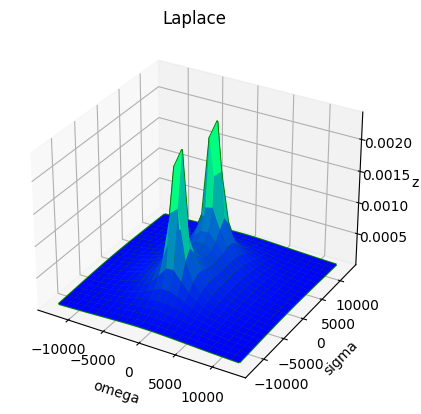

In [14]:
# Desenhar o gráfico 3D de LaPlace
desenharLaplace([float(amp)], [float(b), float(c)])

# Perguntas: <br><br>
a. Para a vogal /a/ determinar a função de laplace --> G(s) = N(s)/D(s). (2.0 pontos) <br><br>
b. Plot sobreposto da vogal com a resposta de Laplace. (2.0 pontos) <br><br>
c. Qual a relação entre Laplace(polos) e Fourier? (1.0 ponto)  <br><br>
d. s = sigma + j w --> G(s) --> visualizar o gráfico do ponto de vista de w. <br>
   Comparando com Fourier qual a conslusão? (1.0 ponto) <br><br>
e. Gerar uma vogal artificial (sintese de voz) de 2 segundos - o mais realista possível (1.0 ponto). <br><br>
 f. Um método automático para determinar o G(s). (2,0 pontos) <br><br>
g. Um circuito elétrico equivalente a vogal. (1.0 ponto) <br><br>

# Resposta das perguntas

In [15]:
# a. Para a vogal /a/ determinar a função de laplace --> G(s) = N(s)/D(s). (2.0 pontos)
print("Item a)")
print(f"Função de Laplace: {criarGs(float(b), float(c), float(amp))}\n")

Item a)
Função de Laplace: 
   1.25e+04
---------------
950 s + 2.1e+07




Item b)
Plot sobreposto:


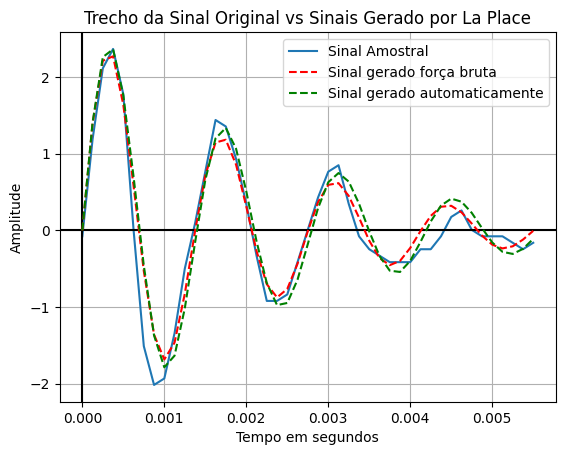

In [16]:
# b. Plot sobreposto da vogal com a resposta de Laplace. (2.0 pontos)
print("Item b)")
print(f'Plot sobreposto:')
serie_resposta_plot = plotar(trecho_t, trecho_Vp, title= "Trecho da Sinal Original vs Sinais Gerado por La Place", dados_label="Sinal Amostral")
serie_resposta_plot.plot(x_impulso, y_impulso, 'r--', label="Sinal gerado força bruta")
serie_resposta_plot.plot(x_impulso_auto, y_impulso_auto, 'g--', label="Sinal gerado automaticamente")
serie_resposta_plot.legend()

Qual a relação entre Laplace(polos) e Fourier?

R: A cordenada y (parte imaginária) do pólo de LaPlace representa a frequência que se encontrara na análise de Fourier



<module 'matplotlib.pyplot' from 'c:\\Users\\rafae\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

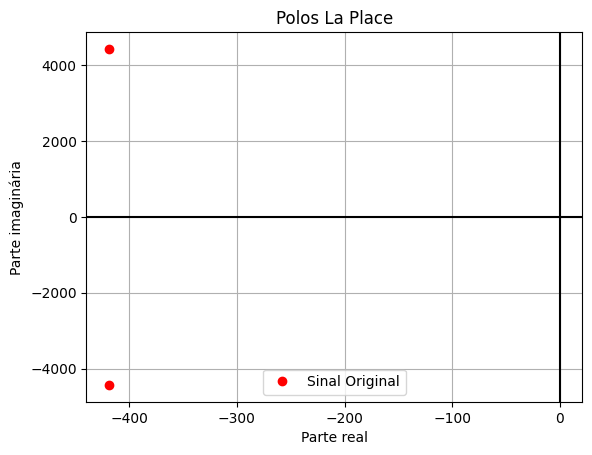

In [17]:
# c. Qual a relação entre Laplace(polos) e Fourier? (1.0 ponto)
print("""Qual a relação entre Laplace(polos) e Fourier?

R: A cordenada y (parte imaginária) do pólo de LaPlace representa a frequência que se encontrara na análise de Fourier
""")
plotar(polos_re, polos_im, dados_type='ro', title="Polos La Place", x_label="Parte real", y_label="Parte imaginária", dados_label="Sinal Original")

Item d)
s = sigma + j w: É possível observar isso recortando um plano do gráfico LaPlace (3d) = sigma=0

Como ficaria o plot 2d com sigma=0


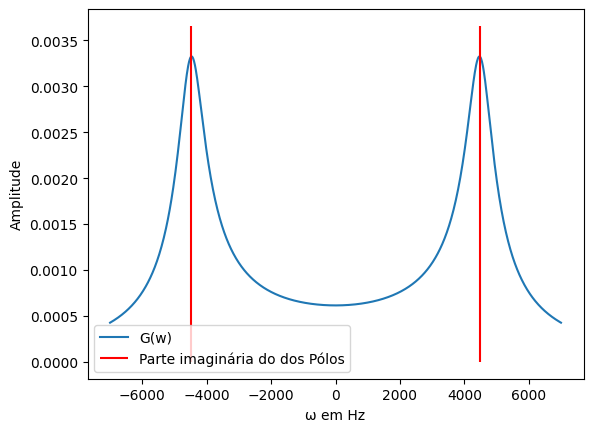

In [18]:
## d. s = sigma + j w --> G(s) --> visualizar o gráfico do ponto de vista de w.
# G(s) = Ns/Ds
print("Item d)")
print("s = sigma + j w: É possível observar isso recortando um plano do gráfico LaPlace (3d) = sigma=0")
print("\nComo ficaria o plot 2d com sigma=0")
sigma = polo1_auto[0]
s_func = lambda x: np.absolute( amp /( b_auto*(1j*x)**2 + c_auto*(1j*x)) )
w_range = np.linspace(-7000, 7000, 1000)
s_range = np.absolute(float(amp) / ( (w_range*1j)**2 + float(b_auto)*(w_range*1j) + float(c_auto)))

plt.figure()
plt.plot(w_range, s_range, label="G(w)")
plt.vlines(polo1_auto[1], ymin=0, ymax=max(s_range)*1.1, color='r', label="Parte imaginária do dos Pólos")
plt.vlines(polo2_auto[1], ymin=0, ymax=max(s_range)*1.1, color='r')
plt.xlabel("ω em Hz")
plt.ylabel("Amplitude")
plt.legend()



In [19]:
### Gerar uma vogal artificial (sintese de voz) de 2 segundos - o mais realista possível (1.0 ponto).
print("Item e)")

# Frequencias de amostragem
freq_amostragem_original = int(len(t) / (t[-1] - t[0]))
freq_amostragem_sintetico_bruta = int(len(x_impulso) / (x_impulso[-1] - x_impulso[0]))
freq_amostragem_sintetico_auto = int(len(x_impulso_auto) / (x_impulso_auto[-1] - x_impulso_auto[0]))

# Definição da duração
duration = 2 # Tempo em segundos

Item e)


In [20]:
print("Vogal original (repetida até dar 2s)")
ipd.Audio(repetir_array(Vp, numero_para_x_segundos(tempo=t, x=duration)), rate=freq_amostragem_original) # load a local WAV file

Vogal original (repetida até dar 2s)


In [21]:
print("Vogal gerada por LaPlace com força Bruta (repetida até dar 2s)")
ipd.Audio(repetir_array(y_impulso, numero_para_x_segundos(tempo=x_impulso, x=duration)), rate=freq_amostragem_sintetico_bruta) # load a local WAV file

Vogal gerada por LaPlace com força Bruta (repetida até dar 2s)


In [22]:
print("Vogal gerada por Laplace automaticamente (repetida até dar 2s)")
ipd.Audio(repetir_array(y_impulso_auto, numero_para_x_segundos(tempo=x_impulso_auto, x=duration)), rate=freq_amostragem_sintetico_auto) # load a local WAV file

Vogal gerada por Laplace automaticamente (repetida até dar 2s)


In [23]:
# f. Um método automático para determinar o G(s). (2,0 pontos

def metodoAutomatico(t, Vp, exibir=False):
    """
    Separa o sinal em trechos, calcula os parametros desses trechos e retorna os parametros que levam a um menor erro
    :param t: vetor tempo
    :param Vp: vetor amplitude
    :param exibir: opção de exibir os gráficos de resultado
    :return: [b, c, amp]
    """
    # Pega os picos gerais
    picos, _ = find_peaks(Vp)

    # Define a média das alturas dos picos como a altura mínima para considerar como pico
    minPeak = np.mean(Vp[picos])
    picos = picos[Vp[picos] > minPeak]

    # Separa os trechos
    quebras = []
    trechos = []
    for i in range(len(picos)-1):
        if Vp[picos[i]] < Vp[picos[i+1]]:
            quebras.append(picos[i+1])

    trechos.append((0, quebras[0])) # Primeiro trecho
    for i in range(len(quebras)-1):
        trechos.append((quebras[i], quebras[i+1]))
    trechos.append((quebras[-1], len(t)-1))  # Último trecho

    NUMERO_REPETICOES_SINAL = len(trechos)



    #### Calcular parametros de cada trecho (frequencia e amortecimento)
    iteracoes = {}
    for trecho in trechos:
        try:
            # Recorta o trecho
            trecho_Vp = Vp[trecho[0]:trecho[1]]
            trecho_t = t[trecho[0]:trecho[1]]

            # Encontrar picos
            peaks, _ = find_peaks(trecho_Vp)

            ## Calcula a frequencia
            peaks_distance = []
            for i in range(len(peaks) - 1):
                peaks_distance.append(trecho_t[peaks[i + 1]] - trecho_t[peaks[i]])

            mean_distance = np.mean(peaks_distance)

            # freq = 1/T    e T = distancia dos picos
            trecho_freq = 1 / mean_distance
            # w = f * 2 * pi
            trecho_omega = trecho_freq * 2 * np.pi


            ## Amortecimento
            result, _ = curve_fit(lambda x, k, m: m * np.exp(-k * x), trecho_t[peaks], trecho_Vp[peaks])
            k, m = result


            #### Método automático
            ## Pegar valores de b e c pelos parametros so gráfico:
            b_auto = 2*k
            c_auto = trecho_omega**2 + b_auto**2

            # Cria o impulso baseado nos valores de b e c automaticos
            amp = '13482.758620689656'
            x_impulso_auto, y_impulso_auto = impulso(amp, b_auto, c_auto, trecho_t)

            y_teste = repetir_array(y_impulso_auto, int(len(Vp)/len(trecho_Vp)))
            iteracoes[trecho] = {
                'erro': calculaErroAjuste(y_teste, Vp, t),
                'parametros': {
                    'b': b_auto,
                    'c':c_auto,
                    'amp': amp
                }
            }
        except RuntimeError:
            pass


    # Pegar o trecho que teve menor erro:
    aux = ["", {'erro': math.inf}]
    for i in iteracoes:
        if iteracoes[i]['erro'] < aux[1]['erro']:
            aux = [i, iteracoes[i]]

    trecho_melhor = aux
    trecho_t = t[0:trecho_melhor[0][1]-trecho_melhor[0][0]]
    trecho_Vp = Vp[trecho_melhor[0][0]:trecho_melhor[0][1]+1]
    parametros = aux[1]["parametros"]
    b = parametros['b']
    c = parametros['c']
    amp = parametros['amp']

    if(exibir):
        # Plota o gráfico
        plot_ = plotar(t, Vp, title="Serie temporal", dados_label="Serie temporal")
        plot_.plot(t[picos], Vp[picos], "xr", label="Picos")  # Plota os picos com pontos vermelho
        plot_.vlines(t[quebras], -max(Vp) * 1.2, max(Vp) * 1.2, colors='r', label="Quebras")
        plot_.legend()

        # Plota o trecho do sinal original com as geradas por La Place

        # Cria o impulso baseado nos valores de b e c automaticos
        x_impulso_auto, y_impulso_auto = impulso(amp, b, c, trecho_t)

        numero_pontos = len(y_impulso_auto) * NUMERO_REPETICOES_SINAL
        trecho_impulso_t = np.linspace(0, t[-1], numero_pontos)

        plotar(trecho_impulso_t, repetir_array(y_impulso_auto, NUMERO_REPETICOES_SINAL), title="Sinal sintético totalmente automatico")

    return b, c, amp

Exemplo do método automático:


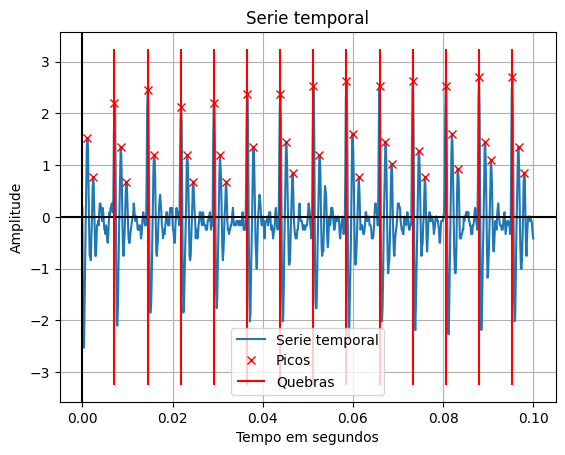

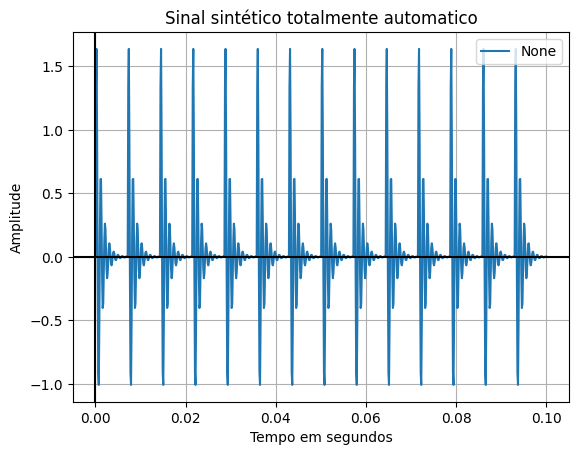

In [24]:
print("Exemplo do método automático:")
b, c, amp_ = metodoAutomatico(t, Vp, True)

x_impulso_auto, y_impulso_auto = impulso(amp_, b, c, trecho_t)

ipd.Audio(repetir_array(y_impulso_auto, numero_para_x_segundos(tempo=x_impulso_auto, x=duration)), rate=freq_amostragem_sintetico_auto) # load a local WAV file

 g. Um circuito elétrico equivalente a vogal. (1.0 ponto)
Circuito RLC em paralelo com fonte de corrente

i(t) = x(t) (entrada do circuito - fonte de corrente que vai fazer um degrau)

y(t) (saida do circúito)

x(t) = $i_r(t) + i_c(t) + i_l(t) $

x(t) = $\frac {y(t)}{R} + \frac{1}{L} \cdot \int_{0}^{t}{y(t)dt} +  C \cdot \frac{dy(t)}{dt}$

Passando para o domínio de LaPlace

X(s) = $  \frac{y(s)} {R} + \frac{1}{L} \cdot \frac{y(s)}{s} + C\cdot sy(s) $

X(s) = $  y(s) \cdot ( \frac{1}{R} + \frac{1}{L} \cdot \frac{1}{s} + C \cdot s) $

X(s) = $  y(s) \cdot \frac{1}{sRL} \cdot ( Ls + R + RLC \cdot s^2) $

Ganho = G(s) = $\frac{saída}{entrada}$ = $\frac{y(s)}{X(s)}$ = $\frac{1}{ \frac{1}{sRL} \cdot ( Ls + R + RLC \cdot s^2)}$

G(s) = $ \frac{sRL}{ Ls + R + RLC \cdot s^2} = \frac{sRL}{ RLC \cdot s^2 \ + \ Ls \ + \ R}$

Algoritmo:

G(s) = $\frac{amp}{s^2 + bs + c}$

$\therefore$

amp = RL (pois o sinal é um degrau, logo multiplicaria por 1/s)

RLC = 1

L = b

R = c

$\therefore$

C = $\frac{1}{bc}$



In [25]:
b_auto = float(b_auto)
c_auto = float(c_auto)

print(f"b: {b_auto}\nc:{c_auto}\n")
print(f"C: {1/(b_auto*c_auto)*10**12:.2f} pF \nL = {b_auto:.2f} H\nR: {c_auto/10**6:.2f} M ohm\n")

b: 837.6249659837374
c:20323376.09344501

C: 58.74 pF 
L = 837.62 H
R: 20.32 M ohm

